In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from concurrent.futures import ThreadPoolExecutor
import os
from tqdm import tqdm
from sklearn.impute import KNNImputer
from sklearn.base import clone
from sklearn.linear_model import LassoCV


In [2]:
# Constants
SEED = 42

In [3]:
INPUT_DIR = "D:/Documents/Github/SC4000_ML/child-mind-institute_problematic-internet-use/data/child-mind-institute-problematic-internet-use/"

In [4]:
# Loading the datasets
train_file_path = "train.csv"
train_df = pd.read_csv(INPUT_DIR + train_file_path)
test_file_path = "test.csv"
test_df = pd.read_csv(INPUT_DIR + test_file_path)
df = train_df

In [5]:
# Basic Info about Dataset
print("\n🔹 Dataset Info:")
print(df.info())


🔹 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898

In [6]:
# Checking for Missing Values
print("\n🔍 Missing Values Count:")
print(df.isnull().sum())


🔍 Missing Values Count:
id                                           0
Basic_Demos-Enroll_Season                    0
Basic_Demos-Age                              0
Basic_Demos-Sex                              0
CGAS-Season                               1405
                                          ... 
SDS-SDS_Total_Raw                         1351
SDS-SDS_Total_T                           1354
PreInt_EduHx-Season                        420
PreInt_EduHx-computerinternet_hoursday     659
sii                                       1224
Length: 82, dtype: int64


In [7]:
# Summary Statistics
print("\n📊 Summary Statistics (Numerical Features):")
print(df.describe())


📊 Summary Statistics (Numerical Features):
       Basic_Demos-Age  Basic_Demos-Sex  CGAS-CGAS_Score  Physical-BMI  \
count      3960.000000      3960.000000      2421.000000   3022.000000   
mean         10.433586         0.372727        65.454771     19.331929   
std           3.574648         0.483591        22.341862      5.113934   
min           5.000000         0.000000        25.000000      0.000000   
25%           8.000000         0.000000        59.000000     15.869350   
50%          10.000000         0.000000        65.000000     17.937682   
75%          13.000000         1.000000        75.000000     21.571244   
max          22.000000         1.000000       999.000000     59.132048   

       Physical-Height  Physical-Weight  Physical-Waist_Circumference  \
count      3027.000000      3076.000000                    898.000000   
mean         55.946713        89.038615                     27.278508   
std           7.473764        44.569040                      5.567287 

In [8]:
# Identify Categorical & Numerical Columns
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

print(f"\n📝 Categorical Columns: {list(categorical_cols)}")
print(f"\n🔢 Numerical Columns: {list(numerical_cols)}")


📝 Categorical Columns: ['id', 'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season']

🔢 Numerical Columns: ['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA

In [9]:
len(numerical_cols)

70

C:\Users\USER\AppData\Local\Temp\ipykernel_27932\2606850753.py:6: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 2000x4200 with 0 Axes>

C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


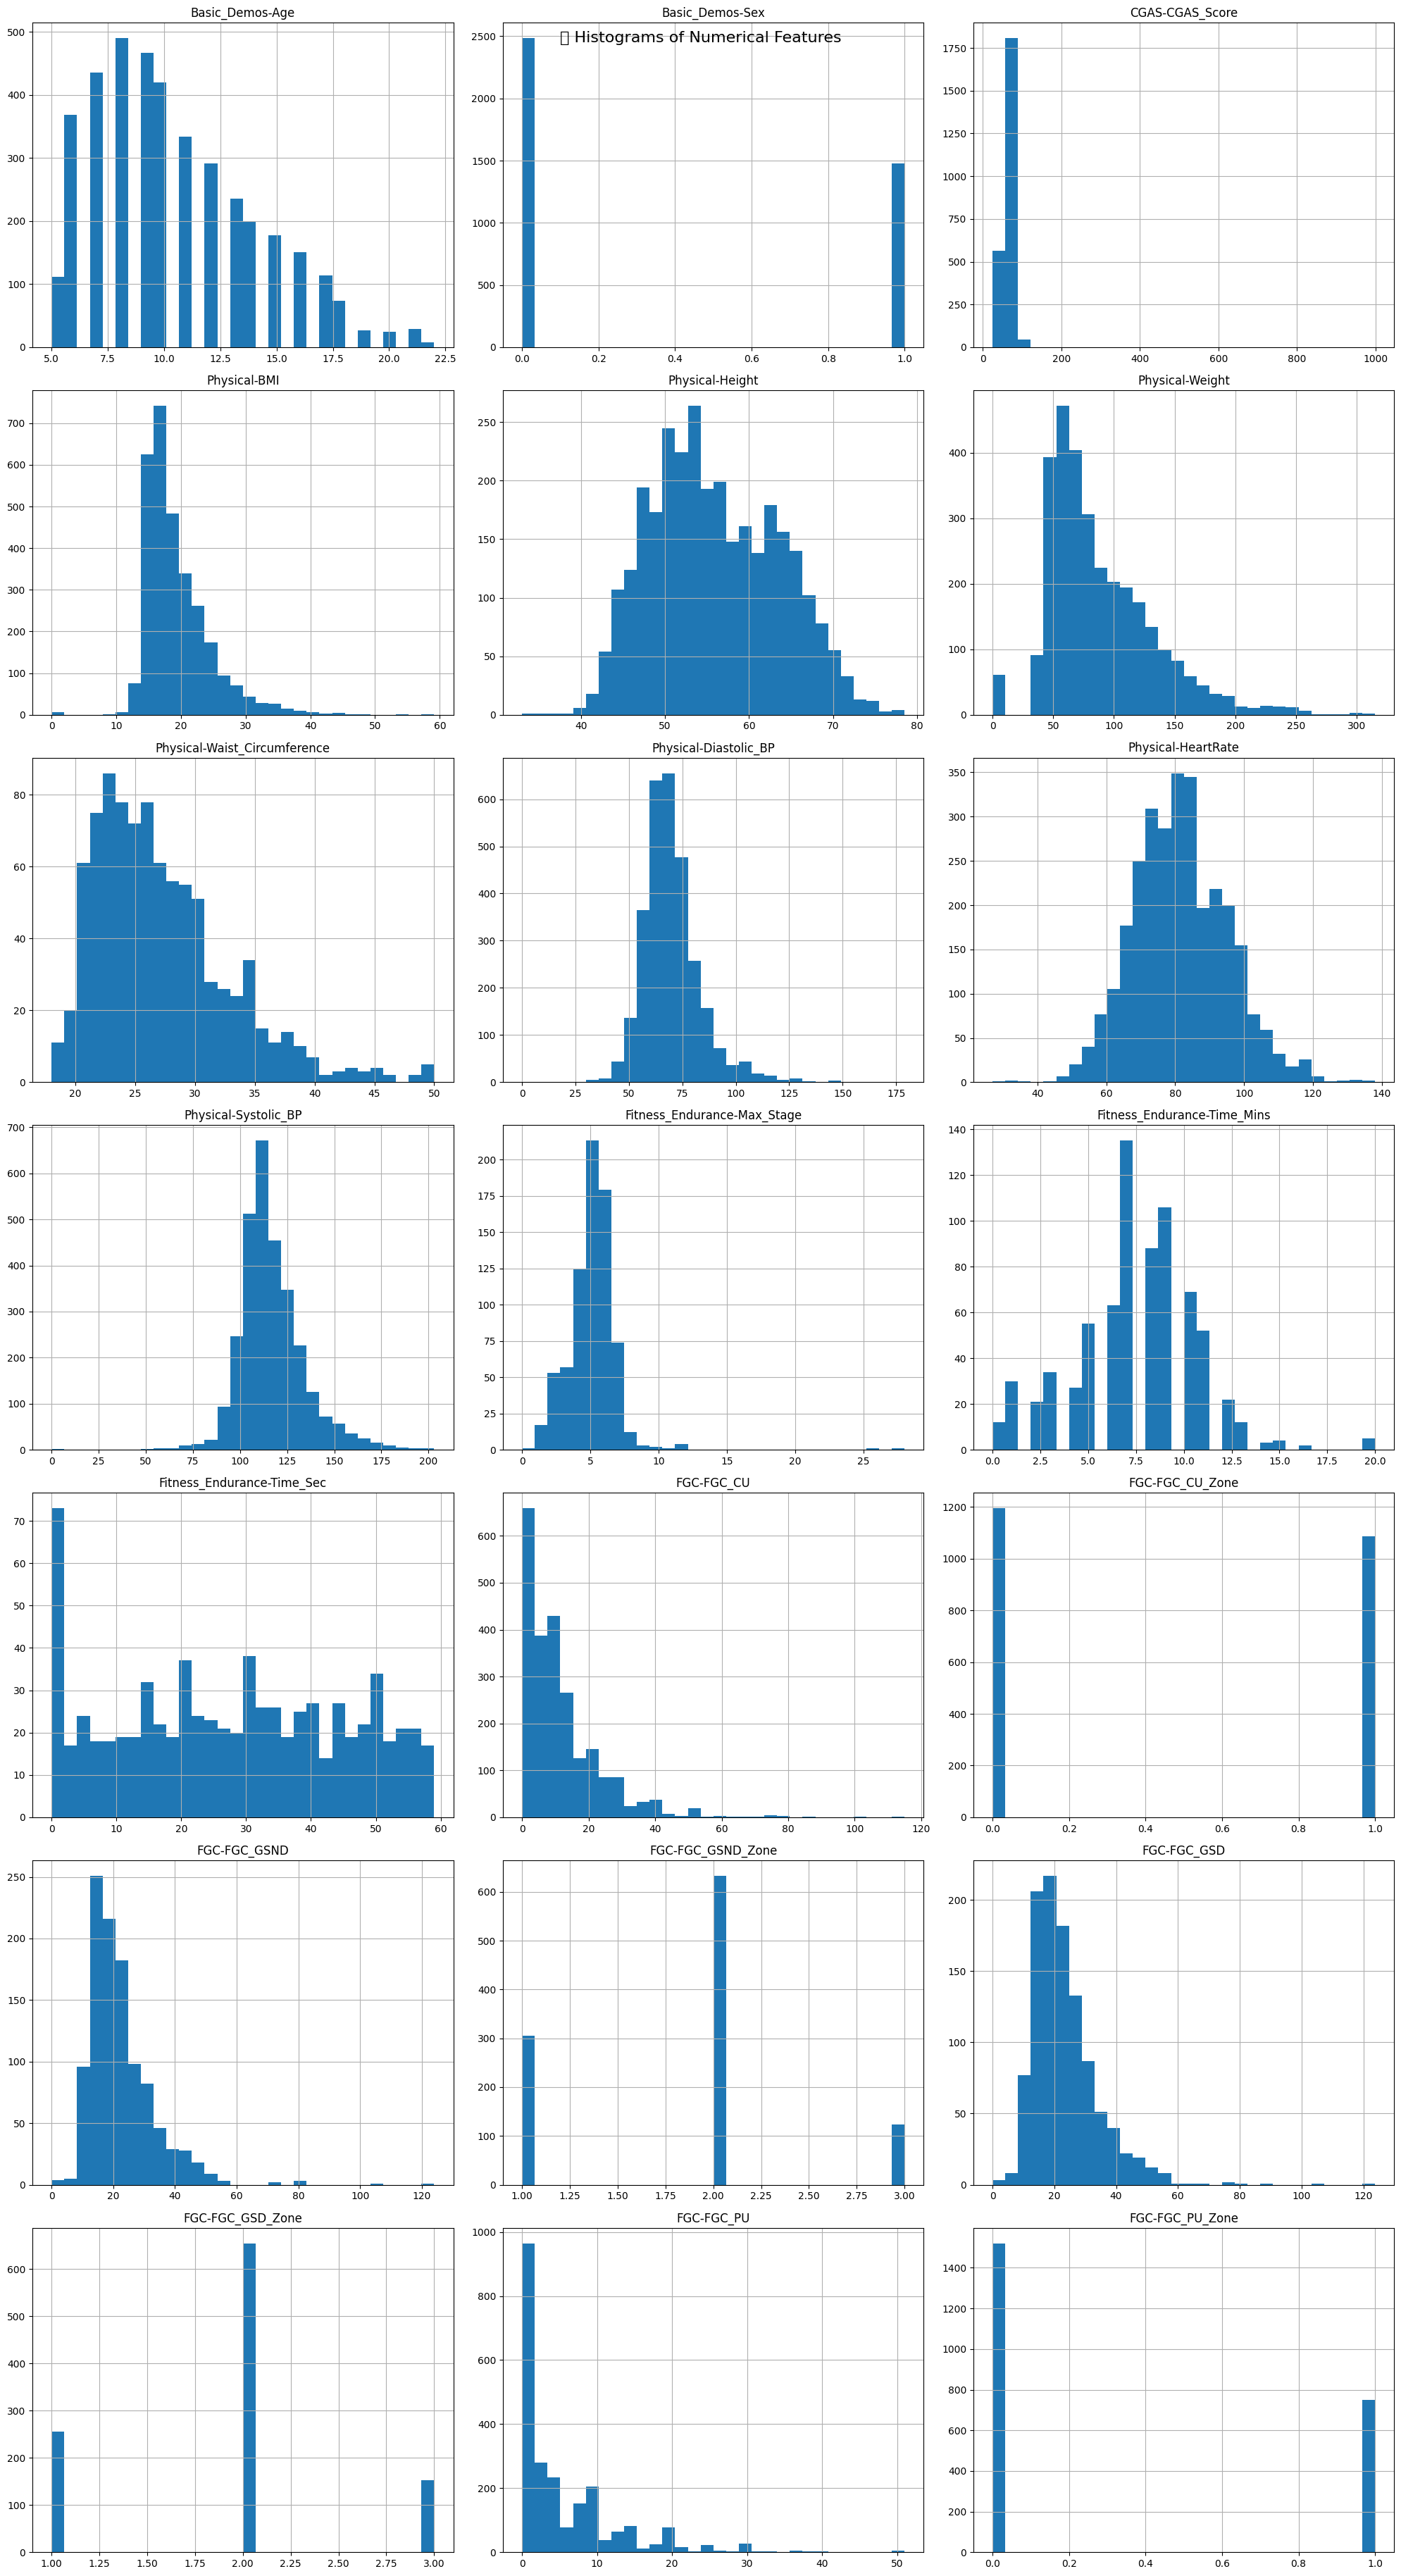

In [10]:
# Plot Histograms for Numerical Data
fig_height = len(numerical_cols[0:21]) * 2 
plt.figure(figsize=(20, fig_height))
df[numerical_cols[0:21]].hist(bins=30, figsize=(20, fig_height), layout=(len(numerical_cols[0:21])//3 + 1, 3))
plt.suptitle("📊 Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_27932\2576632660.py:6: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 2000x4200 with 0 Axes>

C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


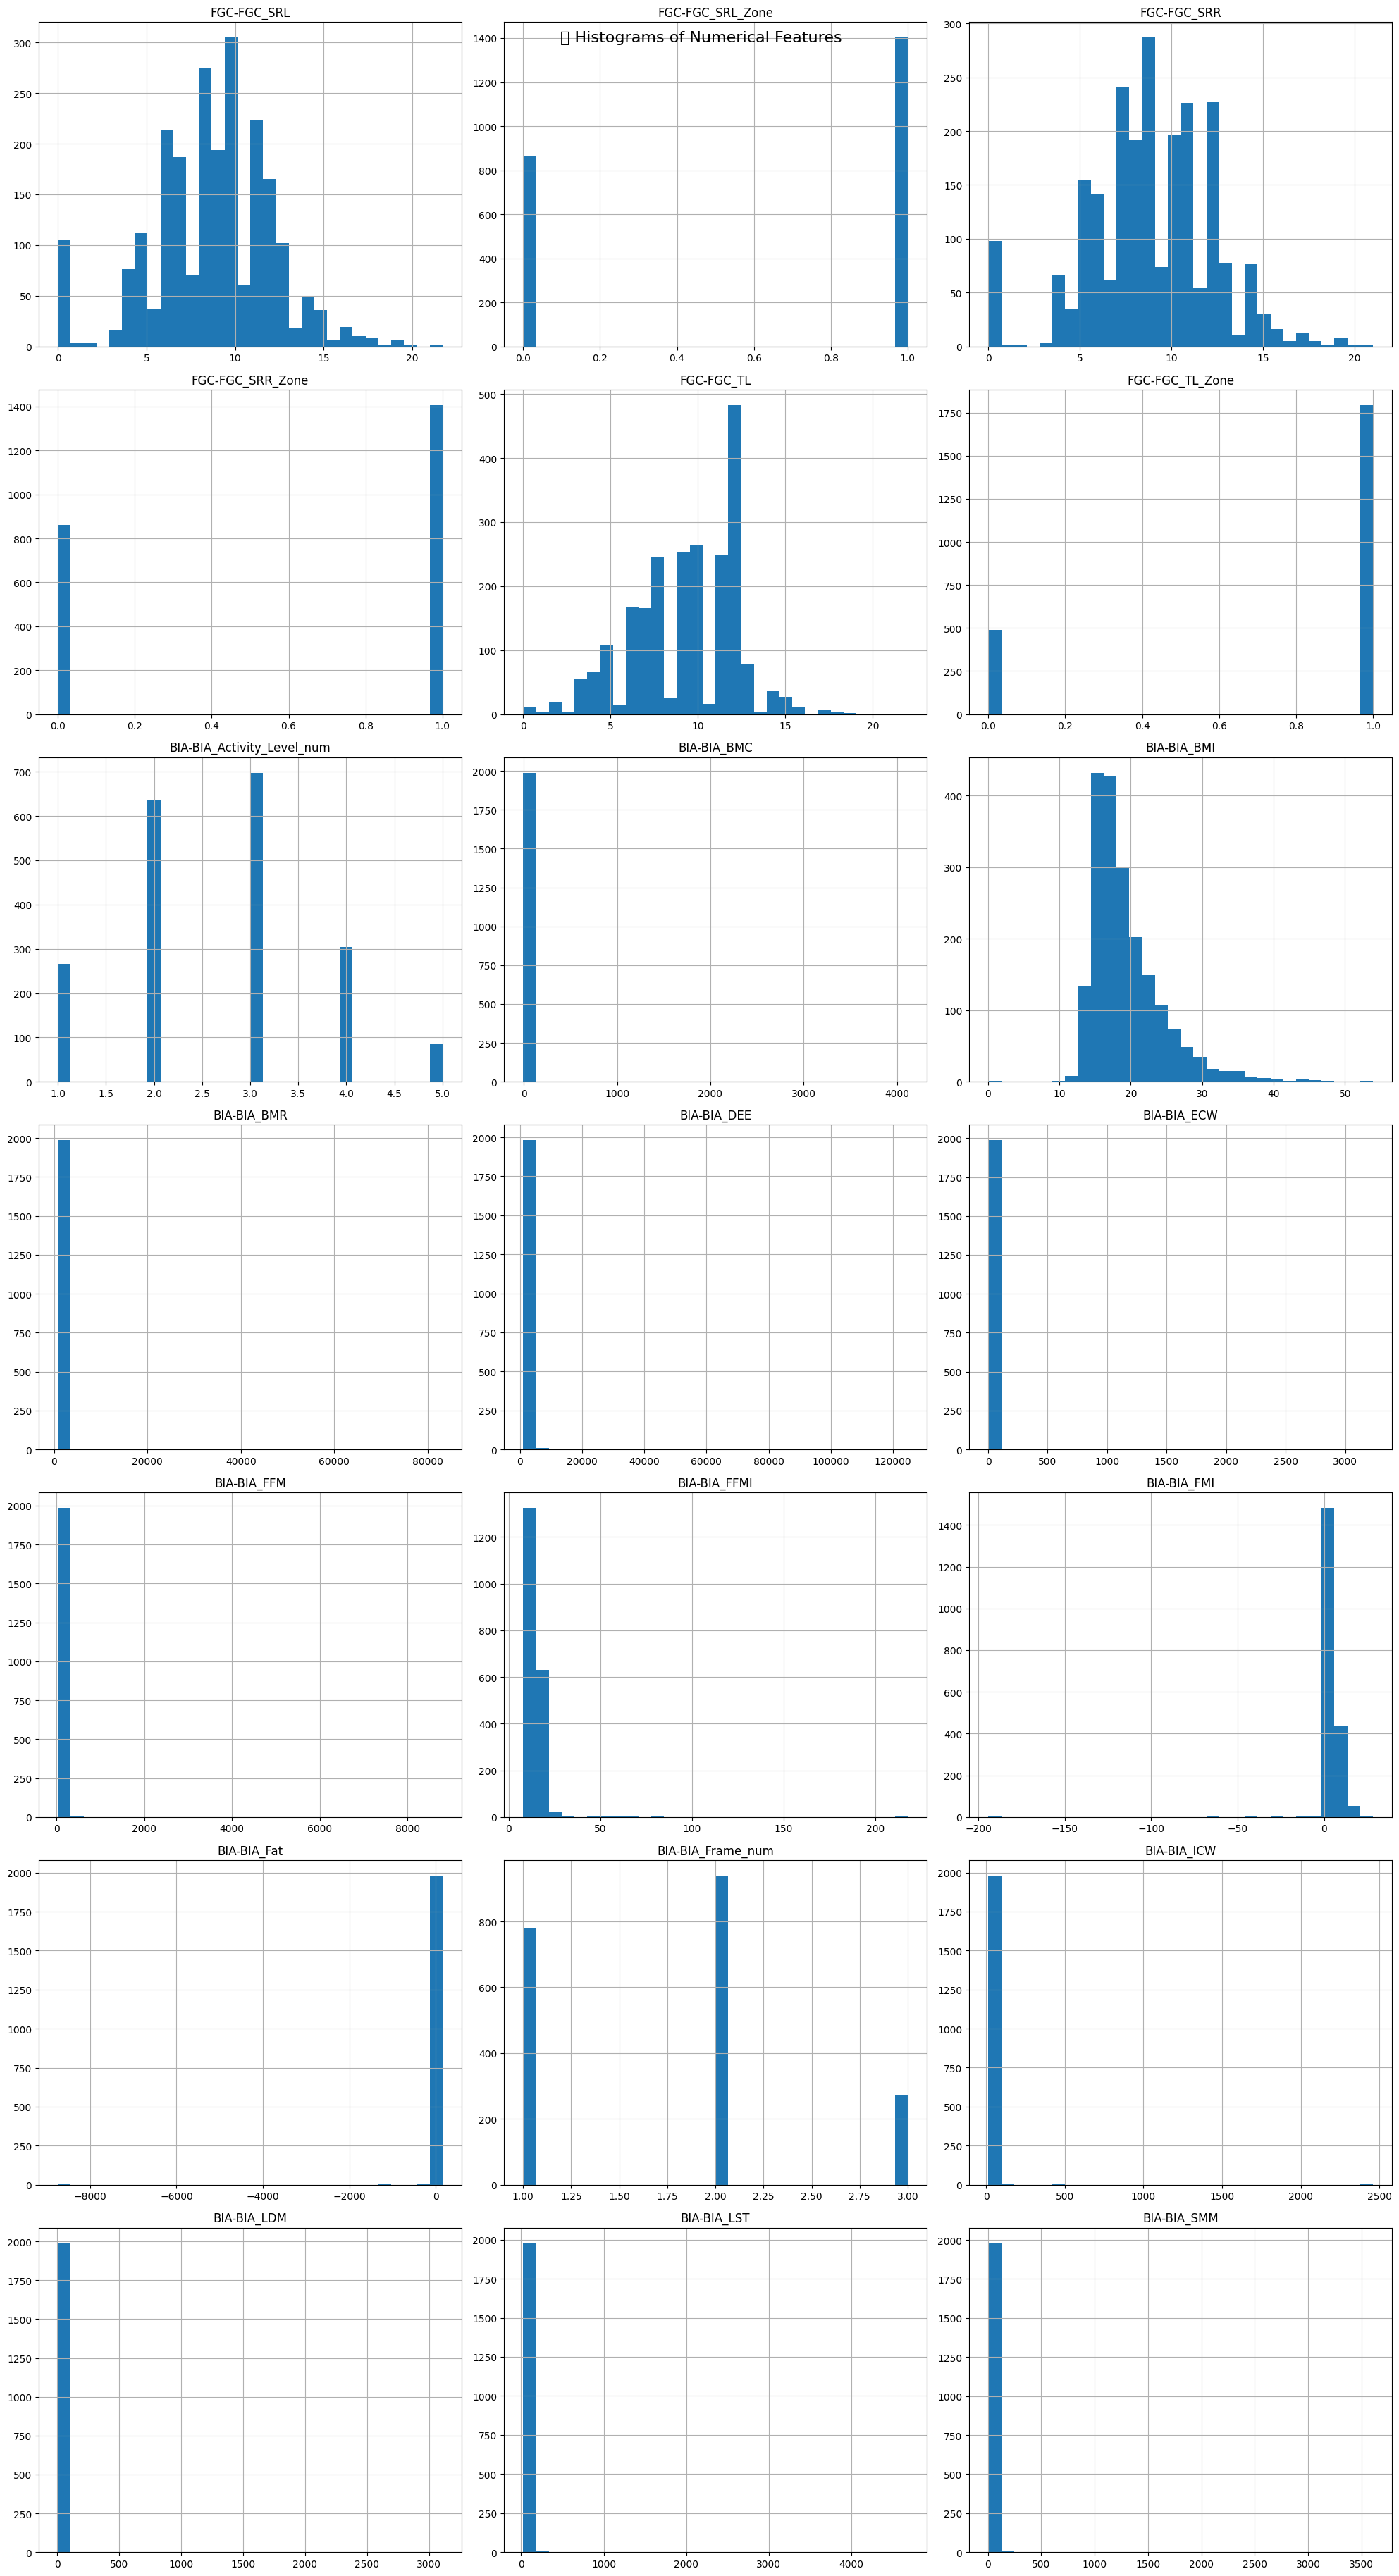

In [11]:
# Plot Histograms for Numerical Data
fig_height = len(numerical_cols[21:42]) * 2 
plt.figure(figsize=(20, fig_height))
df[numerical_cols[21:42]].hist(bins=30, figsize=(20, fig_height), layout=(len(numerical_cols[21:42])//3 + 1, 3))
plt.suptitle("📊 Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()


/var/folders/tn/htz4wbqn6g11g465bmx5l4tr0000gn/T/ipykernel_99792/3264803653.py:6: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()


<Figure size 2000x4200 with 0 Axes>

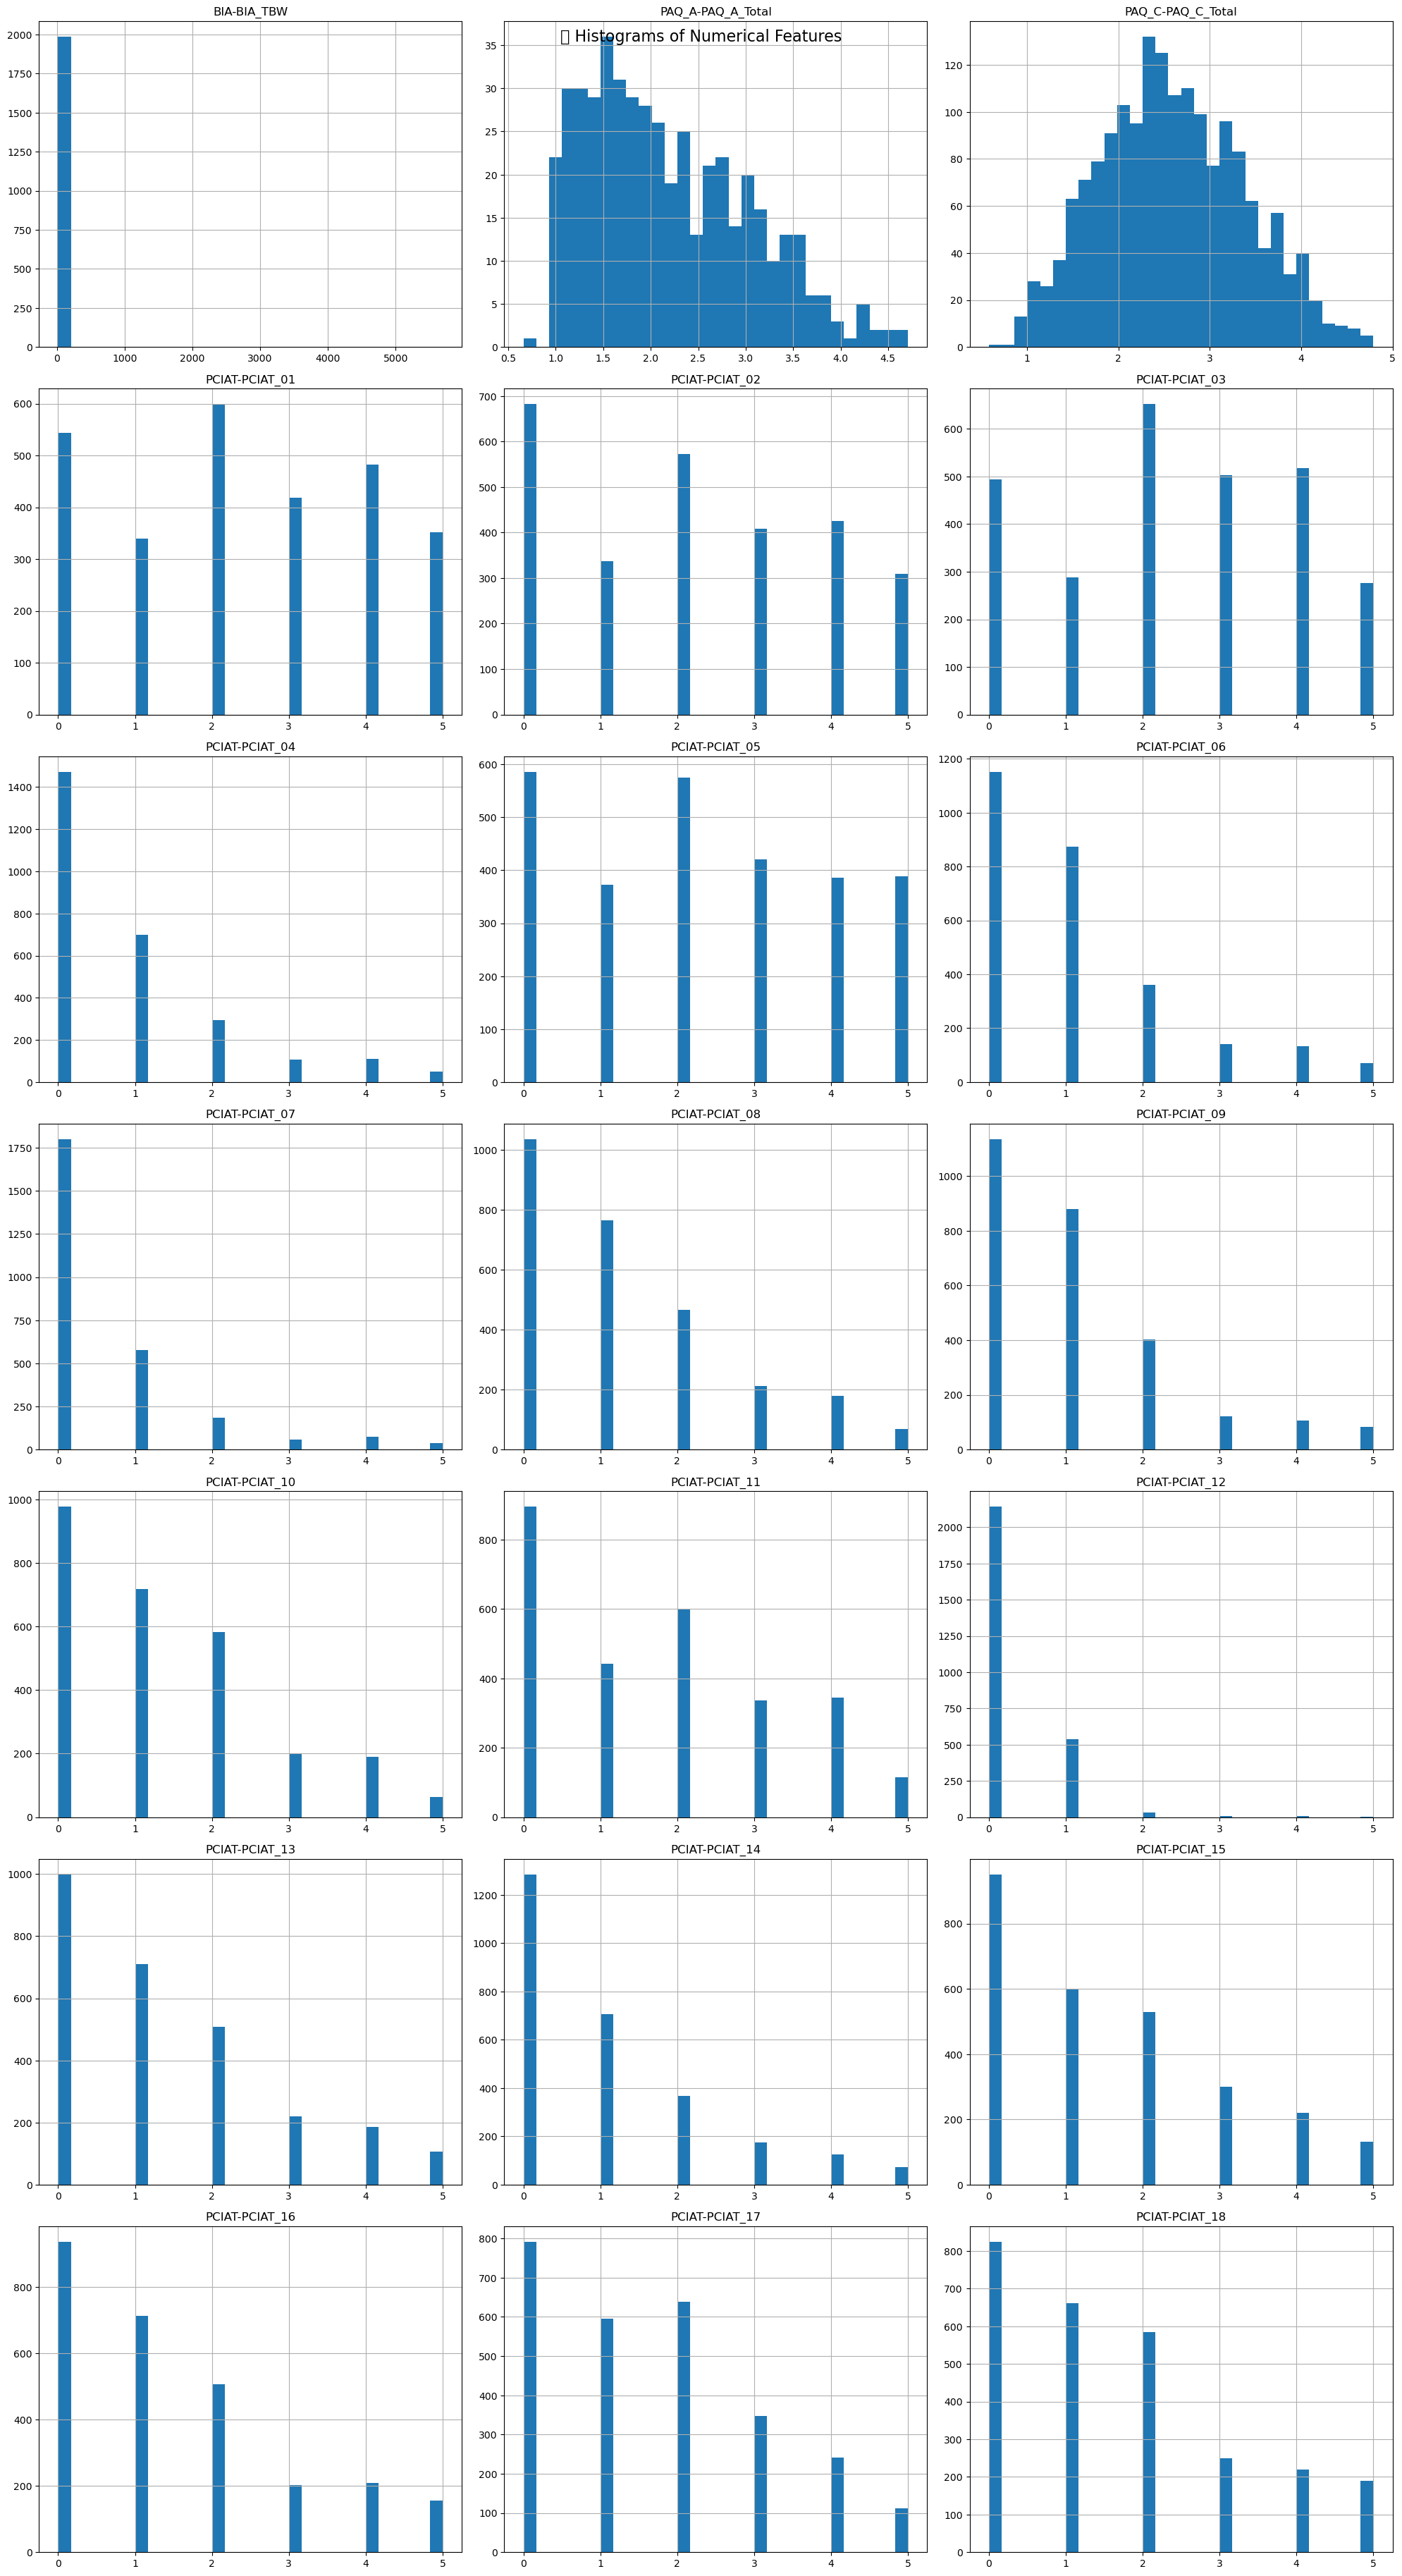

In [11]:
# Plot Histograms for Numerical Data
fig_height = len(numerical_cols[42:63]) * 2 
plt.figure(figsize=(20, fig_height))
df[numerical_cols[42:63]].hist(bins=30, figsize=(20, fig_height), layout=(len(numerical_cols[42:63])//3 + 1, 3))
plt.suptitle("📊 Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()


/var/folders/tn/htz4wbqn6g11g465bmx5l4tr0000gn/T/ipykernel_99792/3835399444.py:6: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()


<Figure size 2000x1400 with 0 Axes>

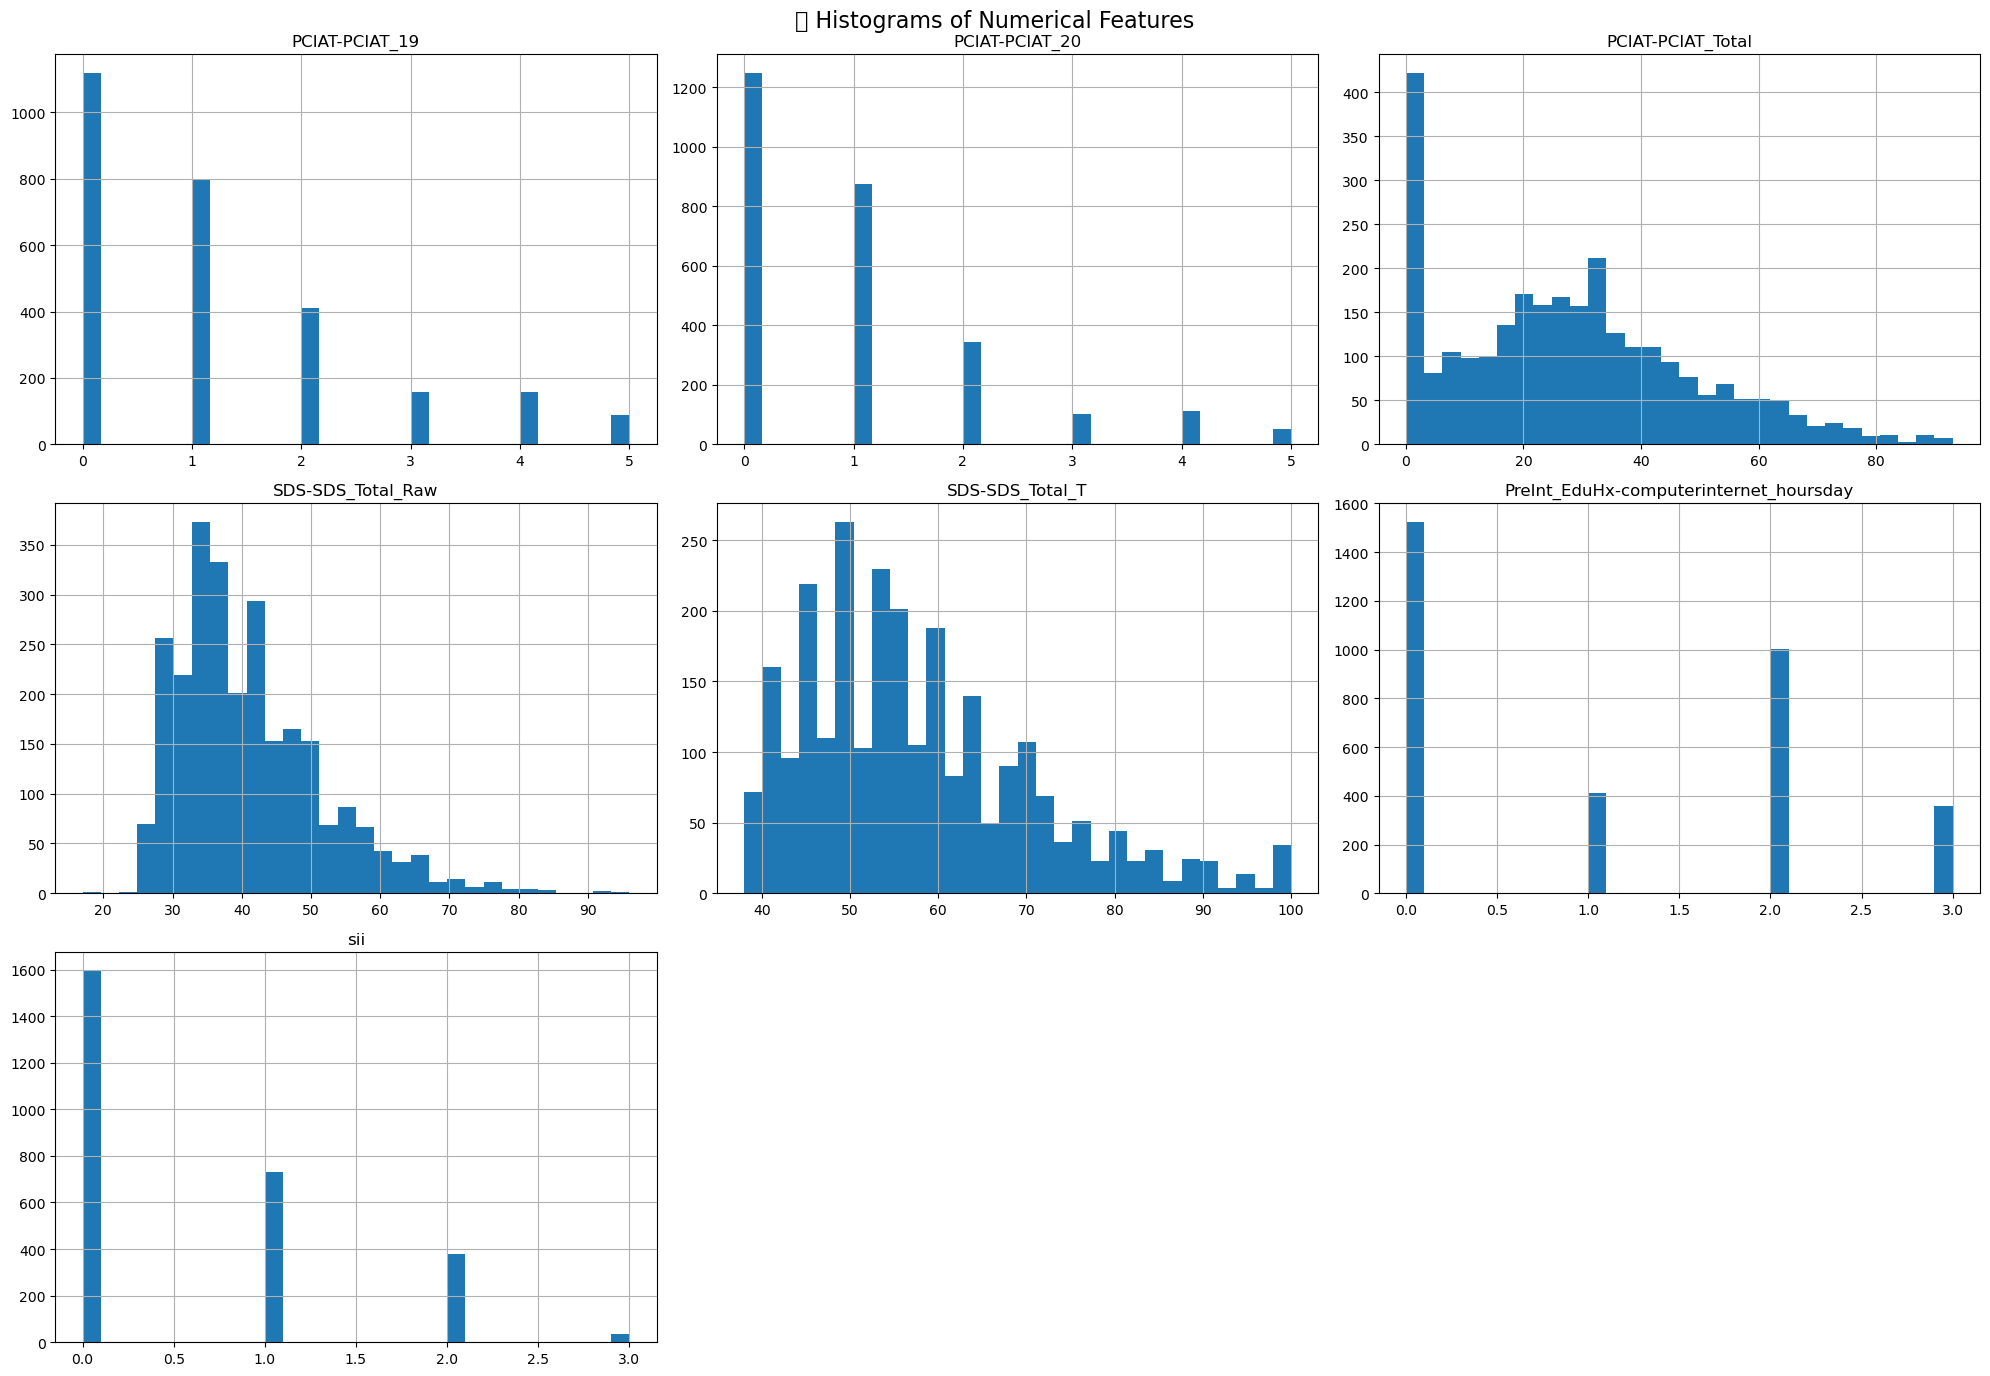

In [12]:
# Plot Histograms for Numerical Data
fig_height = len(numerical_cols[63:]) * 2 
plt.figure(figsize=(20, fig_height))
df[numerical_cols[63:]].hist(bins=30, figsize=(20, fig_height), layout=(len(numerical_cols[63:])//3 + 1, 3))
plt.suptitle("📊 Histograms of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# Displays the minimum and maximum values of the PCIAT-PCIAT_Total column for each sii group.
display(df.groupby('sii').min()['PCIAT-PCIAT_Total'])
display(df.groupby('sii').max()['PCIAT-PCIAT_Total'])

/var/folders/tn/htz4wbqn6g11g465bmx5l4tr0000gn/T/ipykernel_38129/545649613.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  display(df.groupby('sii').min()['PCIAT-PCIAT_Total'])


sii
0.0     0.0
1.0    31.0
2.0    50.0
3.0    80.0
Name: PCIAT-PCIAT_Total, dtype: float64

/var/folders/tn/htz4wbqn6g11g465bmx5l4tr0000gn/T/ipykernel_38129/545649613.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  display(df.groupby('sii').max()['PCIAT-PCIAT_Total'])


sii
0.0    30.0
1.0    49.0
2.0    79.0
3.0    93.0
Name: PCIAT-PCIAT_Total, dtype: float64

In [4]:
## Correlation
covariance_matrix = df.select_dtypes(include=['float64','int64']).corr()
display(covariance_matrix)

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
Basic_Demos-Age,1.000000,0.064004,-0.009994,0.492112,0.880274,0.748149,0.609601,0.107960,-0.218527,0.263875,...,0.085805,0.286888,0.159826,0.303259,0.286309,0.409559,0.037317,0.037115,0.441822,0.365990
Basic_Demos-Sex,0.064004,1.000000,0.075470,0.025793,-0.014454,0.003245,-0.020013,0.002076,0.026675,-0.025256,...,-0.097824,-0.102390,-0.110080,-0.104911,-0.067966,-0.093648,-0.020122,-0.018508,-0.000579,-0.100148
CGAS-CGAS_Score,-0.009994,0.075470,1.000000,-0.094074,-0.023185,-0.076399,-0.076116,-0.005292,-0.010108,-0.021392,...,-0.065687,-0.047770,-0.067922,-0.065210,-0.067920,-0.070542,-0.145369,-0.148457,-0.021596,-0.085261
Physical-BMI,0.492112,0.025793,-0.094074,1.000000,0.487097,0.865662,0.892149,0.141795,-0.036955,0.312045,...,0.071017,0.152122,0.100032,0.181208,0.161034,0.240858,0.087655,0.086185,0.296709,0.221125
Physical-Height,0.880274,-0.014454,-0.023185,0.487097,1.000000,0.833844,0.688033,0.115724,-0.217080,0.299157,...,0.112369,0.300590,0.184409,0.307084,0.292542,0.420765,0.036687,0.036478,0.399367,0.373530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PCIAT-PCIAT_Total,0.409559,-0.093648,-0.070542,0.240858,0.420765,0.353048,0.327013,0.069321,-0.037594,0.147081,...,0.769422,0.823708,0.802030,0.737243,0.754277,1.000000,0.234432,0.237718,0.374124,0.899681
SDS-SDS_Total_Raw,0.037317,-0.020122,-0.145369,0.087655,0.036687,0.075098,0.089831,0.006702,0.049194,0.036562,...,0.250015,0.177323,0.239387,0.171186,0.209167,0.234432,1.000000,0.996134,0.083501,0.229692
SDS-SDS_Total_T,0.037115,-0.018508,-0.148457,0.086185,0.036478,0.073482,0.091152,0.008502,0.047932,0.038317,...,0.252715,0.180220,0.241844,0.173366,0.209338,0.237718,0.996134,1.000000,0.086050,0.232982
PreInt_EduHx-computerinternet_hoursday,0.441822,-0.000579,-0.021596,0.296709,0.399367,0.375851,0.371418,0.074258,-0.073453,0.137728,...,0.180736,0.299658,0.223794,0.290488,0.245310,0.374124,0.083501,0.086050,1.000000,0.336526


In [12]:
def clean_data(df):
    
    season_colums = [col for col in train_df.columns if 'Season' in col]
    df = df.drop(season_colums, axis=1) # Removes columns with 'Season' in the name
    
    df["BIA-BIA_Fat"] = df["BIA-BIA_Fat"].abs() # Replaces negative values with positive values

    df["BIA-BIA_FMI"] = df["BIA-BIA_FMI"].abs() # Replaces negative values with positive values

    df.loc[df["BIA-BIA_Fat"] > 65, "BIA-BIA_Fat"] = np.nan # Replaces values greater than 65 with NaN - more than 65% body fat is not possible

    df.loc[df["BIA-BIA_Fat"] < 5, "BIA-BIA_Fat"] = np.nan # Replaces values less than 5 with NaN - less 5% body fat is not possible

    df.loc[df["BIA-BIA_FMI"] > 40, "BIA-BIA_FMI"] = np.nan # Replaces values greater than 40 with NaN

    df[['FGC-FGC_GSND', 'FGC-FGC_GSD']] = df[['FGC-FGC_GSND', 'FGC-FGC_GSD']].clip(lower=0, upper=100) # Replaces values less than 0 with 0 and values greater than 100 with 100

    df.loc[df["BIA-BIA_BMR"] > 4000, "BIA-BIA_BMR"] = np.nan # Replaces values greater than 4000 with NaN

    df.loc[df["BIA-BIA_DEE"] > 8000, "BIA-BIA_DEE"] = np.nan # Replaces values greater than 8000 with NaN

    df["BIA-BIA_BMC"] = df["BIA-BIA_BMC"].abs() # Replaces negative values with positive values

    df[['BIA-BIA_BMC']] = df[['BIA-BIA_BMC']].clip(lower=0, upper=10) # Replaces values less than 0 with 0 and values greater than 10 with 10

    df.loc[df["BIA-BIA_BMC"] == 0, "BIA-BIA_BMC"] = np.nan # Replaces values equal to 0 with NaN

    df.loc[df["BIA-BIA_FFM"] > 400, "BIA-BIA_FFM"] = np.nan # Replaces values greater than 400 with NaN

    df.loc[df["BIA-BIA_ECW"] > 100, "BIA-BIA_ECW"] = np.nan # Replaces values greater than 100 with NaN

    df.loc[df["BIA-BIA_ICW"] > 100, "BIA-BIA_ICW"] = np.nan # Replaces values greater than 100 with NaN

    df.loc[df["BIA-BIA_LDM"] > 100, "BIA-BIA_LDM"] = np.nan # Replaces values greater than 100 with NaN

    df.loc[df["BIA-BIA_LST"] > 300, "BIA-BIA_LST"] = np.nan # Replaces values greater than 300 with NaN

    df.loc[df["BIA-BIA_TBW"] > 300, "BIA-BIA_TBW"] = np.nan # Replaces values greater than 300 with NaN

    df.loc[df["BIA-BIA_SMM"] > 300, "BIA-BIA_SMM"] = np.nan # Replaces values greater than 300 with NaN

    df.loc[df["Physical-Height"] == 0, "Physical-Height"] = np.nan # Replaces values equal to 0 with NaN

    df.loc[df["Physical-Weight"] == 0, "Physical-Weight"] = np.nan # Replaces values equal to 0 with NaN

    df['PAQ_Total'] = df['PAQ_C-PAQ_C_Total'].fillna(df['PAQ_A-PAQ_A_Total']) # Fills missing values in PAQ_Total with values from PAQ_A-PAQ_A_Total

    df = df.drop('PAQ_C-PAQ_C_Total', axis=1) 
    df = df.drop('PAQ_A-PAQ_A_Total', axis=1)

    return df

train_df = clean_data(train_df)
test_df = clean_data(test_df)

In [13]:
# Quick function to display the statistics of a column
def get_statistic(df_col):
    print(df_col.describe())

def assign_groups(age):
    thresholds = [5, 10, 15, 18, 22]  # Define the thresholds based on the age groups.
    for i, j in enumerate(thresholds):
        if age <= j:
            return i
    return np.nan

def group_statistics(df, column):
    mean_value = df.groupby('age_group')[column].mean() # Calculate the mean value of the column for each age group.
    print(mean_value)

train_df['age_group'] = train_df['Basic_Demos-Age'].apply(assign_groups) # Apply the function to the 'Demographics-Age' column.
test_df['age_group'] = test_df['Basic_Demos-Age'].apply(assign_groups) # Apply the function to the 'Demographics-Age' column.



In [14]:
def time_features(df):
    # Convert time_of_day to hours
    df["hours"] = df["time_of_day"] // (3_600 * 1_000_000_000)
    # Basic features 
    features = [
        df["non-wear_flag"].mean(),
        df["enmo"][df["enmo"] >= 0.05].sum(),
    ]
    
    # Define conditions for night, day, and no mask (full data)
    night = ((df["hours"] >= 21) | (df["hours"] <= 5))
    day = ((df["hours"] <= 20) & (df["hours"] >= 6))
    no_mask = np.ones(len(df), dtype=bool)
    
    # List of columns of interest and masks
    keys = ["enmo", "anglez", "light", "battery_voltage"]
    masks = [no_mask, night, day]
    
    # Helper function for feature extraction
    def extract_stats(data):
        return [
            data.mean(), 
            data.std(), 
            data.max(), 
            data.min(), 
            data.diff().mean(), 
            data.diff().std()
        ]
    
    # Iterate over keys and masks to generate the statistics
    for key in keys:
        for mask in masks:
            filtered_data = df.loc[mask, key]
            features.extend(extract_stats(filtered_data))

    return features

def process_file(filename, dirname):
    # Process file and extract time features
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return time_features(df), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    # Load time series from directory in parallel
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    
    return df

In [16]:
train_ts = load_time_series(INPUT_DIR + "series_train.parquet")

  0%|          | 1/996 [00:04<1:15:58,  4.58s/it]


KeyboardInterrupt: 

In [62]:
test_ts = load_time_series("series_test.parquet")

100%|██████████| 2/2 [00:00<00:00, 11.37it/s]


In [63]:
# Principal Component Analysis
def perform_pca(train, test, n_components=None, random_state=42):
    
    pca = PCA(n_components=n_components, random_state=random_state)
    train_pca = pca.fit_transform(train)
    test_pca = pca.transform(test)
    
    explained_variance_ratio = pca.explained_variance_ratio_
    print(f"Explained variance ratio of the components:\n {explained_variance_ratio}")
    print(np.sum(explained_variance_ratio))
    
    train_pca_df = pd.DataFrame(train_pca, columns=[f'PC_{i+1}' for i in range(train_pca.shape[1])])
    test_pca_df = pd.DataFrame(test_pca, columns=[f'PC_{i+1}' for i in range(test_pca.shape[1])])
    
    return train_pca_df, test_pca_df, pca

In [ ]:
# Processing the time series data and merging with the main dataset
df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

scaler = StandardScaler() 
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns)
df_test = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)

for c in df_train.columns:
    m = np.mean(df_train[c])
    df_train[c].fillna(m, inplace=True)
    df_test[c].fillna(m, inplace=True)

print(df_train.shape)

df_train_pca, df_test_pca, pca = perform_pca(df_train, df_test, n_components=15, random_state=SEED)

df_train_pca['id'] = train_ts['id']
df_test_pca['id'] = test_ts['id']

train = pd.merge(train_df, df_train_pca, how="left", on='id')
test = pd.merge(test_df, df_test_pca, how="left", on='id')
train.shape

(996, 74)
Explained variance ratio of the components:
 [0.2297803  0.11595334 0.07236788 0.06201337 0.05346817 0.04800129
 0.0408818  0.03782128 0.03380817 0.02967952 0.02575016 0.0241788
 0.02183349 0.02151956 0.01905743]
0.8361145330748827


(3960, 86)

In [19]:
# Features to exclude, because they're not in test
exclude = ['PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03',
           'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07',
           'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11',
           'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15',
           'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19',
           'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii', 'id']

y_model = "PCIAT-PCIAT_Total" # Score, target for the model
y_comp = "sii" # Index, target of the competition
features = [f for f in train.columns if f not in exclude]

In [20]:
class Impute_With_Model:
    
    def __init__(self, na_frac=0.5, min_samples=0):
        self.model_dict = {}
        self.mean_dict = {}
        self.features = None
        self.na_frac = na_frac
        self.min_samples = min_samples
        
    def find_features(self, data, feature, tmp_features):
        missing_rows = data[feature].isna()
        na_fraction = data[missing_rows][tmp_features].isna().mean(axis=0)
        valid_features = np.array(tmp_features)[na_fraction <= self.na_frac]
        return valid_features

    def fit_models(self, model, data, features):
        self.features = features
        n_data = data.shape[0]
        for feature in features:
            self.mean_dict[feature] = np.mean(data[feature])
        for feature in tqdm(features):
            if data[feature].isna().sum() > 0:
                model_clone = clone(model)
                X = data[data[feature].notna()].copy()
                tmp_features = [f for f in features if f != feature]
                tmp_features = self.find_features(data, feature, tmp_features)
                if len(tmp_features) >= 1 and X.shape[0] > self.min_samples:
                    for f in tmp_features:
                        X[f] = X[f].fillna(self.mean_dict[f])
                    model_clone.fit(X[tmp_features], X[feature])
                    self.model_dict[feature] = (model_clone, tmp_features.copy())
                else:
                    self.model_dict[feature] = ("mean", np.mean(data[feature]))
            
    def impute(self, data):
        imputed_data = data.copy()
        for feature, model in self.model_dict.items():
            missing_rows = imputed_data[feature].isna()
            if missing_rows.any():
                if model[0] == "mean":
                    imputed_data[feature].fillna(model[1], inplace=True)
                else:
                    tmp_features = [f for f in self.features if f != feature]
                    X_missing = data.loc[missing_rows, tmp_features].copy()
                    for f in tmp_features:
                        X_missing[f] = X_missing[f].fillna(self.mean_dict[f])
                    imputed_data.loc[missing_rows, feature] = model[0].predict(X_missing[model[1]])
        return imputed_data
    
    def impute_test(self, data):
        imputed_data = data.copy()
        for feature, model in self.model_dict.items():
            if feature in exclude:
                continue
            missing_rows = imputed_data[feature].isna()
            if missing_rows.any():
                if model[0] == "mean":
                    imputed_data[feature].fillna(model[1], inplace=True)
                else:
                    tmp_features = [f for f in self.features if f != feature]
                    X_missing = data.loc[missing_rows, tmp_features].copy()
                    for f in tmp_features:
                        X_missing[f] = X_missing[f].fillna(self.mean_dict[f])
                    imputed_data.loc[missing_rows, feature] = model[0].predict(X_missing[model[1]])
        return imputed_data

In [79]:
model = LassoCV(cv=5, random_state=SEED)
imputer = Impute_With_Model(na_frac=0.4) 
# na_frac is the maximum fraction of missing values until which a feature is imputed with the model
# if there are more missing values than for example 40% then we revert to mean imputation
imputer.fit_models(model, train, features)
train_impute = imputer.impute(train)


100%|██████████| 63/63 [00:03<00:00, 15.88it/s]


In [80]:
test_impute = imputer.impute_test(test)

In [74]:
# Checking for Missing Values
print("\n🔍 Missing Values Count:")
print(train_impute.isnull().sum())


🔍 Missing Values Count:
id                 0
Basic_Demos-Age    0
Basic_Demos-Sex    0
CGAS-CGAS_Score    0
Physical-BMI       0
                  ..
PC_11              0
PC_12              0
PC_13              0
PC_14              0
PC_15              0
Length: 86, dtype: int64


In [ ]:
train_impute['PCIAT_Total_Imputed'] = train_impute[['PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03',
           'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07',
           'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PsCIAT_10', 'PCIAT-PCIAT_11',
           'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15',
           'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19',
           'PCIAT-PCIAT_20']].sum(axis=1)


In [84]:
to_save = train_impute[['id', 'PCIAT_Total_Imputed', 'PCIAT-PCIAT_Total']]
to_save.to_csv("imputed_values.csv", index=False)

In [86]:
train_impute.to_csv("train_imputed_values.csv", index=False)

### Feature Engineering

In [ ]:
train = train_df
test= test_df

In [43]:
thresholds = [5, 10, 15, 18, 22]

In [50]:
def assign_group(age, thresholds):
    for i, j in enumerate(thresholds):
        if age <= j:
            return i
    return np.nan

In [54]:
train["group"] = train['Basic_Demos-Age'].apply(lambda age: assign_group(age, thresholds))
test["group"] = test['Basic_Demos-Age'].apply(lambda age: assign_group(age, thresholds))

In [55]:
cu_map = {}
pu_map = {}
tl_map = {}
gs_max_map = {}
gs_min_map = {}
bmr_map = {}
dee_map = {}
sr_min_map = {}
sr_max_map = {}
ffmi_map = {}


prev = 0
for i in range(len(thresholds)):
    curr = thresholds[i]
    mean_cu = train[(train['Basic_Demos-Age'] > prev) & (train['Basic_Demos-Age'] <= curr)]['FGC-FGC_CU'].mean()
    mean_pu = train[(train['Basic_Demos-Age'] > prev) & (train['Basic_Demos-Age'] <= curr)]['FGC-FGC_PU'].mean()
    mean_tl = train[(train['Basic_Demos-Age'] > prev) & (train['Basic_Demos-Age'] <= curr)]['FGC-FGC_TL'].mean()
    mean_gs_max = train[(train['Basic_Demos-Age'] > prev) & (train['Basic_Demos-Age'] <= curr)]['GS_max'].mean()
    mean_gs_min = train[(train['Basic_Demos-Age'] > prev) & (train['Basic_Demos-Age'] <= curr)]['GS_min'].mean()
    mean_bmr = train[(train['Basic_Demos-Age'] > prev) & (train['Basic_Demos-Age'] <= curr)]['BIA-BIA_BMR'].mean()
    mean_dee = train[(train['Basic_Demos-Age'] > prev) & (train['Basic_Demos-Age'] <= curr)]['BIA-BIA_DEE'].mean()
    mean_sr_min = train[(train['Basic_Demos-Age'] > prev) & (train['Basic_Demos-Age'] <= curr)]['SR_min'].mean()
    mean_sr_max = train[(train['Basic_Demos-Age'] > prev) & (train['Basic_Demos-Age'] <= curr)]['SR_max'].mean()
    mean_ffmi = train[(train['Basic_Demos-Age'] > prev) & (train['Basic_Demos-Age'] <= curr)]['BIA-BIA_FFMI'].mean()
    cu_map[i] = mean_cu
    pu_map[i] = mean_pu
    tl_map[i] = mean_tl
    gs_max_map[i] = mean_gs_max
    gs_min_map[i] = mean_gs_min
    bmr_map[i] = mean_bmr
    dee_map[i] = mean_dee
    sr_min_map[i] = mean_sr_min
    sr_max_map[i] = mean_sr_max
    ffmi_map[i] = mean_ffmi
    
    prev = curr

In [56]:
print("cu_map: ", cu_map)
print("pu_map: ", pu_map)
print("tl_map: ", tl_map)
print("gs_max_map", gs_max_map)
print("gs_min_map", gs_min_map)
print("bmr_map", bmr_map)
print("dee_map", dee_map)
print("sr_min_map", sr_min_map)
print("sr_max_map", sr_max_map)
print("ffmi_map", ffmi_map)

cu_map:  {0: 1.4891304347826086, 1: 7.3164362519201225, 2: 17.046195652173914, 3: 20.4, 4: 23.142857142857142}
pu_map:  {0: 0.7065217391304348, 1: 4.097842835130971, 2: 7.517808219178082, 3: 10.437158469945356, 4: 15.285714285714286}
tl_map:  {0: 7.9021739130434785, 1: 8.714543361473522, 2: 10.135054347826086, 3: 10.193548387096774, 4: 9.428571428571429}
gs_max_map {0: nan, 1: 16.049668874172184, 2: 23.792010943912448, 3: 32.56924731182796, 4: 40.642857142857146}
gs_min_map {0: nan, 1: 14.086026490066224, 2: 21.14311901504788, 3: 28.671505376344083, 4: 34.800000000000004}
bmr_map {0: 934.2936000000002, 1: 1044.4710360036004, 2: 1351.50534318555, 3: 1562.4434319526626, 4: 1615.6395}
dee_map {0: 1471.1115, 1: 1733.4984878487849, 2: 2303.2957471264367, 3: 2621.1362721893493, 4: 2722.585}
sr_min_map {0: 9.256043956043955, 1: 8.503477588871716, 2: 7.748975409836065, 3: 8.251612903225807, 4: 8.25}
sr_max_map {0: 10.187912087912089, 1: 9.44308346213292, 2: 8.690437158469946, 3: 9.350537634408

In [ ]:
def bin_data(train, test, columns, n_bins=10):
    # Combine train and test for consistent bin edges
    combined = pd.concat([train, test], axis=0)

    bin_edges = {}
    for col in columns:
        # Compute quantile bin edges correctly
        edges = pd.qcut(combined[col], n_bins, retbins=True, labels=False, duplicates="drop")[1]
        bin_edges[col] = edges

    # Apply the same bin edges to both train and test
    for col, edges in bin_edges.items():
        num_bins = len(edges) - 1  # Ensure the correct number of labels
        labels = range(num_bins)   # Matching labels with bins

        train[col] = pd.cut(train[col], bins=edges, labels=labels, include_lowest=True).astype(float)
        test[col] = pd.cut(test[col], bins=edges, labels=labels, include_lowest=True).astype(float)

    return train, test

In [58]:
def feature_engineering(df):

    df['GS_max'] = df[['FGC-FGC_GSND', 'FGC-FGC_GSD']].max(axis=1)
    df['GS_min'] = df[['FGC-FGC_GSND', 'FGC-FGC_GSD']].min(axis=1)

    df["SR_min"] = df[['FGC-FGC_SRL', 'FGC-FGC_SRR']].min(axis=1)
    df["SR_max"] = df[['FGC-FGC_SRL', 'FGC-FGC_SRR']].max(axis=1)

    df["CU_norm"] = df['FGC-FGC_CU'] / df['group'].map(cu_map)
    df["PU_norm"] = df['FGC-FGC_PU'] / df['group'].map(pu_map)
    df["TL_norm"] = df['FGC-FGC_TL'] / df['group'].map(tl_map)

    df['GS_max_norm'] = df['GS_max'] / df["group"].map(gs_max_map)
    df['GS_min_norm'] = df['GS_min'] / df["group"].map(gs_min_map)

    df['SR_max_norm'] = df['SR_max'] / df["group"].map(gs_max_map)
    df['SR_min_norm'] = df['SR_min'] / df["group"].map(gs_min_map)

    df["BMR_norm"] = df["BIA-BIA_BMR"] / df["group"].map(bmr_map)
    df["DEE_norm"] = df["BIA-BIA_DEE"] / df["group"].map(dee_map)

    df["FFMI_norm"] = df["BIA-BIA_FFMI"] / df["group"].map(ffmi_map)

    df["ECW_ICW_ratio"] = df["BIA-BIA_ECW"] / df["BIA-BIA_ICW"]

In [90]:
columns_to_remove = ['Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                    'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                    'BIA-BIA_BMI', 'BIA-BIA_FFM', 'BIA-BIA_FMI','BIA-BIA_Frame_num', 'BIA-BIA_LDM']

In [60]:
columns_to_bin = [
    "CU_norm", "PU_norm", "TL_norm", "GS_min_norm", "GS_max_norm", 
    "SR_min_norm", "SR_max_norm", "BMR_norm", "DEE_norm", "FFMI_norm", "Physical-HeartRate", "Physical-Waist_Circumference", "Physical-Height" ,"Physical-Weight"
]

In [61]:
feature_engineering(train)

In [62]:
feature_engineering(test)

In [74]:
train, test = bin_data(train, test, columns_to_bin, n_bins=10)

Created bin edges


In [84]:
train.columns

Index(['id', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score',
       'Physical-BMI', 'Physical-Height', 'Physical-Weight',
       'Physical-Waist_Circumference', 'Physical-Diastolic_BP',
       'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins',
       'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone',
       'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone',
       'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone',
       'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
       'BIA-BIA_TBW', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03',
       'PCIAT-PCIAT_04', 'PCIAT-P

In [91]:
train = train.drop(columns_to_remove, axis=1)

In [92]:
test = test.drop(columns_to_remove, axis=1)